In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In [2]:
def get_taxonomy(df):
    taxonomy = {}
    ranks = ["superkingdom","phylum","class","order","family","genus","species"]
    _df = df.fillna("")
    for bin_id in _df.index:
        taxonomy[bin_id] = {}
        t = _df.loc[bin_id,"Taxonomy (contained)"]
        t = t.split("(")[0].rstrip()
        if t=="":
            for r in ranks:
                taxonomy[bin_id][r] = "Unclassified"
            continue
        items = t.split(";")
        items = [x.split("_")[-1] for x in items]
        for i, item in enumerate(items):
            if ranks[i] == "species" and item!="":
                taxonomy[bin_id][ranks[i]] = "{} {}".format(items[i-1],item)
            else:
                taxonomy[bin_id][ranks[i]] = item
        last_known = items[-1]
        for i in range(len(items),len(ranks)):
            taxonomy[bin_id][ranks[i]] = "Unclassified.{}".format(last_known)
    return pd.DataFrame(taxonomy).T[ranks]

In [3]:
min_comp = 50
max_cont = 5

Read checkm results for CONCOCT.

In [5]:
co_res = pd.read_csv("results/checkm.concoct.tsv", header=0, sep="\t", index_col=0)
co_res = pd.merge(co_res, get_taxonomy(co_res), left_index=True, right_index=True)
co_res = co_res.assign(assembly=pd.Series([".".join(x.split(".")[0:-2]) for x in co_res.index], index=co_res.index))

In [6]:
co_counts = co_res.loc[(co_res.Completeness>=min_comp)&(co_res.Contamination<=max_cont)].groupby(["superkingdom","assembly"]).count().reset_index().loc[:,["superkingdom","assembly","# genomes"]]
co_counts = co_counts.assign(binner=pd.Series(["CONCOCT"]*len(co_counts), index=co_counts.index))
co_size = co_res.loc[(co_res.Completeness>=min_comp)&(co_res.Contamination<=max_cont),["Genome size (bp)","assembly"]].groupby("assembly").sum()
co_size = co_size.assign(binner=pd.Series(["CONCOCT"]*len(co_size), index=co_size.index))

Read checkm results for maxbin2

In [7]:
ma_res = pd.read_csv("results/checkm.maxbin2.tsv", sep="\t", index_col=0, header=0)
ma_res = pd.merge(ma_res, get_taxonomy(ma_res), left_index=True, right_index=True)
ma_res = ma_res.assign(assembly=pd.Series([".".join(x.split(".")[0:-2]) for x in ma_res.index], index=ma_res.index))

In [8]:
ma_counts = ma_res.loc[(ma_res.Completeness>=min_comp)&(ma_res.Contamination<=max_cont)].groupby(["superkingdom","assembly"]).count().reset_index().loc[:,["superkingdom","assembly","# genomes"]]
ma_counts = ma_counts.assign(binner=pd.Series(["MaxBin2"]*len(ma_counts), index=ma_counts.index))
ma_size = ma_res.loc[(ma_res.Completeness>=min_comp)&(ma_res.Contamination<=max_cont),["Genome size (bp)","assembly"]].groupby("assembly").sum()
ma_size = ma_size.assign(binner=pd.Series(["MaxBin2"]*len(ma_size), index=ma_size.index))

## Metabat2

Read checkm results for Metabat

In [9]:
mb_res = pd.read_csv("results/checkm.metabat2.tsv", header=0, sep="\t", index_col=0)
mb_res = pd.merge(mb_res, get_taxonomy(mb_res), left_index=True, right_index=True)
mb_res = mb_res.assign(assembly=pd.Series([".".join(x.split(".")[0:-2]) for x in mb_res.index], index=mb_res.index))

In [10]:
mb_counts = mb_res.loc[(mb_res.Completeness>=min_comp)&(mb_res.Contamination<=max_cont)].groupby(["superkingdom","assembly"]).count().reset_index().loc[:,["superkingdom","assembly","# genomes"]]
mb_counts = mb_counts.assign(binner=pd.Series(["MetaBat2"]*len(mb_counts), index=mb_counts.index))
mb_size = mb_res.loc[(mb_res.Completeness>=min_comp)&(mb_res.Contamination<=max_cont),["Genome size (bp)","assembly"]].groupby("assembly").sum()
mb_size = mb_size.assign(binner=pd.Series(["MetaBat2"]*len(mb_size), index=mb_size.index))

## Total good quality counts per binner and assembly

In [11]:
counts = pd.concat([ma_counts,co_counts,mb_counts])

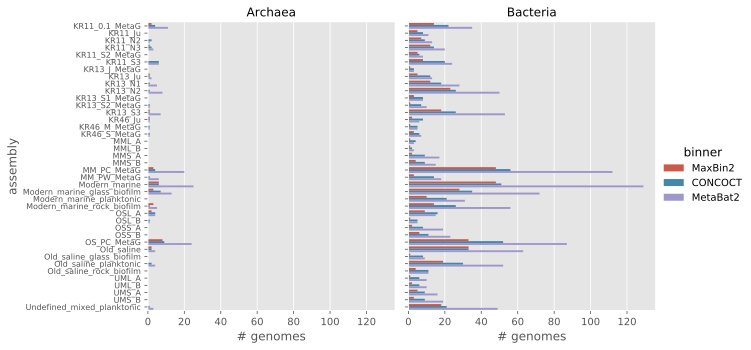

In [12]:
ax = sns.catplot(data=counts, x="# genomes", y="assembly", col="superkingdom", hue="binner", hue_order=["MaxBin2","CONCOCT","MetaBat2"], kind="bar", order=sorted(ma_counts.assembly.unique()), height=5)
ax.set_titles("{col_name}");
ax.set_yticklabels(fontsize=8);
plt.savefig("figures/bin_eval.genomes_per_kingdom.png", dpi=300, bbox_inches="tight")

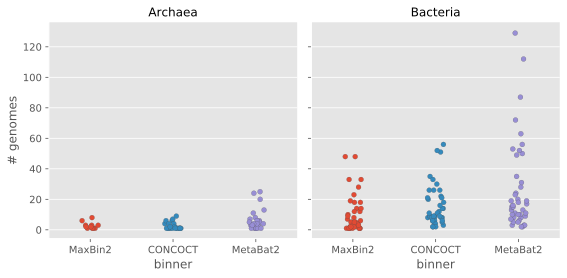

In [14]:
ax = sns.catplot(data=counts, y="# genomes", x="binner", col="superkingdom", 
                 kind="strip", height=4, order=["MaxBin2","CONCOCT","MetaBat2"], linewidth=.2)
ax.set_titles("{col_name}");
plt.savefig("figures/bin_eval.genomes_per_binner.png", dpi=300, bbox_inches="tight")

## Total binned size

In [15]:
size = pd.concat([co_size.reset_index(), ma_size.reset_index(), mb_size.reset_index()])
size.sample(10)

,assembly,Genome size (bp),binner
12,KR13_S3,51094360,MaxBin2
3,KR11_N3,30347986,MaxBin2
35,Old_saline_planktonic,161620027,MetaBat2
22,Modern_marine,148283958,MaxBin2
1,KR11_Ju,31340729,MetaBat2
10,KR13_N2,66817299,CONCOCT
9,KR13_N1,74260268,MetaBat2
14,KR46_Ju,21180472,MetaBat2
37,UMS_A,17562616,MaxBin2
22,MM_PW_MetaG,46998149,CONCOCT


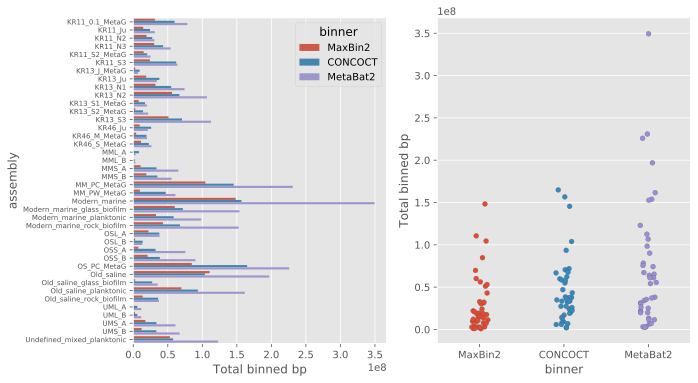

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,6))
ax1 = sns.barplot(data=size, x="Genome size (bp)", y="assembly", hue="binner", hue_order=["MaxBin2","CONCOCT","MetaBat2"], order=sorted(ma_counts.assembly.unique()), ax=axes[0])
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=7);
ax1.set_xlabel("Total binned bp");

ax2 = sns.stripplot(data=size, x="binner", y="Genome size (bp)", ax=axes[1], 
                    order=["MaxBin2","CONCOCT","MetaBat2"], linewidth=.2)
ax2.set_ylabel("Total binned bp");
plt.savefig("figures/bin_eval.total_binned.png", dpi=300, bbox_inches="tight")